In [41]:
import numpy as np
import pandas as pd

In [42]:
#test case requirement matrix IFPR 
R = np.array([
    # FP_count      Complexity     Time          Cost          R_Priority
    [[0.5, 0.5],   [0.7, 0.2],   [0.6, 0.3],   [0.8, 0.1],   [0.7, 0.2]],  # FP_count
    [[0.2, 0.7],   [0.5, 0.5],   [0.6, 0.3],   [0.7, 0.2],   [0.6, 0.3]],  # Complexity
    [[0.3, 0.6],   [0.3, 0.6],   [0.5, 0.5],   [0.6, 0.3],   [0.5, 0.4]],  # Time
    [[0.1, 0.8],   [0.2, 0.7],   [0.3, 0.6],   [0.5, 0.5],   [0.4, 0.5]],  # Cost
    [[0.2, 0.7],   [0.3, 0.6],   [0.4, 0.5],   [0.5, 0.4],   [0.5, 0.5]]   # R_Priority
])

In [43]:
def construct_perfect_multiplicative_consistent_ifpr(R):
    """
    Constructs the Perfect Multiplicative Consistent IFPR (R_bar) from the original IFPR R.
    
    For i < k, if we define the chain over t = i+1, ..., k-1, then:
    
       μ̃(i,k) = { [∏ₜ ( μ(i,t) * μ(t,k) )]^(exponent) } /
                  { [∏ₜ ( μ(i,t) * μ(t,k) )]^(exponent) + [∏ₜ ( (1-μ(i,t)) * (1-μ(t,k)) )]^(exponent) }
    
       ν̃(i,k) is defined similarly using ν.
    
    The exponent is chosen as follows:
      - If chain length = (k - i - 1) equals 1, exponent = 1.
      - If chain length > 1, exponent = 0.5 (i.e. take square root).
    
    For adjacent indices (k = i+1), the original values are kept.
    The lower-triangular part is filled by reciprocity:
      R_bar[k,i] = (ν̃(i,k), μ̃(i,k))
    """
    n = R.shape[0]
    R_bar = np.zeros((n, n, 2), dtype=float)

    # 1. Set diagonal entries to (0.5, 0.5)
    for i in range(n):
        R_bar[i, i] = [0.5, 0.5]

    # 2. Compute upper-triangular entries
    for i in range(n):
        for k in range(i+1, n):
            if k == i + 1:
                # For adjacent indices, simply use the original value.
                R_bar[i, k] = R[i, k]
            else:
                exponent = 1.0 / (k - i - 1)
                # Compute chain-products for membership
                prod_mu = 1.0
                prod_1mu = 1.0
                for t in range(i+1, k):
                    prod_mu   *= (R[i, t, 0] * R[t, k, 0])
                    prod_1mu  *= ((1 - R[i, t, 0]) * (1 - R[t, k, 0]))
                left_mu  = prod_mu ** exponent
                right_mu = prod_1mu ** exponent
                denom_mu = left_mu + right_mu
                new_mu = left_mu / denom_mu if denom_mu != 0 else 0.5

                # Compute chain-products for non-membership
                prod_nu = 1.0
                prod_1nu = 1.0
                for t in range(i+1, k):
                    prod_nu   *= (R[i, t, 1] * R[t, k, 1])
                    prod_1nu  *= ((1 - R[i, t, 1]) * (1 - R[t, k, 1]))
                left_nu  = prod_nu ** exponent
                right_nu = prod_1nu ** exponent
                denom_nu = left_nu + right_nu
                new_nu = left_nu / denom_nu if denom_nu != 0 else 0.5

                R_bar[i, k] = [new_mu, new_nu]

    # 3. Fill the lower-triangular part using reciprocity:
    # If R_bar[i,k] = (μ, ν), then set R_bar[k,i] = (ν, μ).
    for i in range(n):
        for k in range(i+1, n):
            mu_val, nu_val = R_bar[i, k]
            R_bar[k, i] = [nu_val, mu_val]

    return R_bar

In [44]:
# Construct the Perfect Multiplicative Consistent IFPR
R_bar = construct_perfect_multiplicative_consistent_ifpr(R)

# Print results with better formatting
np.set_printoptions(precision=4, suppress=True)
print("Original R (upper triangle):")
print(R[..., 0], "\n", R[..., 1], "\n")  # Print membership (μ) and non-membership (ν) matrices

print("Perfect Multiplicative Consistent IFPR (R_bar):")

# Dynamically determine the size of the matrix
n = R.shape[0]  # Number of rows (and columns, since it's an N x N matrix)

# Loop through each row and column dynamically
for i in range(n):
    row_str = []
    for k in range(n):
        mu_val = R_bar[i, k, 0]
        nu_val = R_bar[i, k, 1]
        row_str.append(f"({mu_val:.4f}, {nu_val:.4f})")
    print(f"Row {i+1}:", "\t".join(row_str))

Original R (upper triangle):
[[0.5 0.7 0.6 0.8 0.7]
 [0.2 0.5 0.6 0.7 0.6]
 [0.3 0.3 0.5 0.6 0.5]
 [0.1 0.2 0.3 0.5 0.4]
 [0.2 0.3 0.4 0.5 0.5]] 
 [[0.5 0.2 0.3 0.1 0.2]
 [0.7 0.5 0.3 0.2 0.3]
 [0.6 0.6 0.5 0.3 0.4]
 [0.8 0.7 0.6 0.5 0.5]
 [0.7 0.6 0.5 0.4 0.5]] 

Perfect Multiplicative Consistent IFPR (R_bar):
Row 1: (0.5000, 0.5000)	(0.7000, 0.2000)	(0.7778, 0.0968)	(0.7778, 0.0968)	(0.7068, 0.1307)
Row 2: (0.2000, 0.7000)	(0.5000, 0.5000)	(0.6000, 0.3000)	(0.6923, 0.1552)	(0.6044, 0.2109)
Row 3: (0.0968, 0.7778)	(0.3000, 0.6000)	(0.5000, 0.5000)	(0.6000, 0.3000)	(0.5000, 0.3000)
Row 4: (0.0968, 0.7778)	(0.1552, 0.6923)	(0.3000, 0.6000)	(0.5000, 0.5000)	(0.4000, 0.5000)
Row 5: (0.1307, 0.7068)	(0.2109, 0.6044)	(0.3000, 0.5000)	(0.5000, 0.4000)	(0.5000, 0.5000)


In [45]:
def check_consistency(R, R_bar, tau=0.1):
    """
    Computes the distance d between the original IFPR matrix R and 
    the perfectly multiplicative consistent IFPR matrix R_bar using:
    
      d(R, R_bar) = (1 / ((n-1) * (n-2))) * sum_{i=1}^{n} sum_{k=i+1}^{n} 
                     [|mu_bar(i,k) - mu(i,k)| + |nu_bar(i,k) - nu(i,k)| + |pi_bar(i,k) - pi(i,k)|],
                     
    where for each entry,
      pi(i,k) = 1 - mu(i,k) - nu(i,k) and
      pi_bar(i,k) = 1 - mu_bar(i,k) - nu_bar(i,k).
    
    Parameters:
      R      : Original IFPR matrix (n x n x 2 numpy array)
      R_bar  : Consistent IFPR matrix (n x n x 2 numpy array)
      tau    : Threshold for acceptable consistency (default: 0.1)
    
    Returns:
      (bool) True if d < tau, else False.
    """
    n = R.shape[0]
    total_diff = 0.0
    
    # Loop over the upper triangular indices (i < k)
    for i in range(n):
        for k in range(i+1, n):
            mu = R[i, k, 0]
            nu = R[i, k, 1]
            pi = 1 - mu - nu
            
            mu_bar = R_bar[i, k, 0]
            nu_bar = R_bar[i, k, 1]
            pi_bar = 1 - mu_bar - nu_bar
            
            diff = abs(mu_bar - mu) + abs(nu_bar - nu) + abs(pi_bar - pi)
            total_diff += diff
    
    # Use normalization factor as in the paper: (n-1)*(n-2) or 2*(n-1)(n-2) idk man
    denominator = 2*(n - 1) * (n - 2)
    d = total_diff / denominator
    
    print("Distance d(R, R_bar) =", d)
    return d < tau

In [46]:
R_bar = construct_perfect_multiplicative_consistent_ifpr(R)
    
# Check consistency:
consistent = check_consistency(R, R_bar, tau=0.1)
if consistent:
    print("The IFPR is consistent (d < 0.1).")
else:
    print("The IFPR is NOT consistent (d >= 0.1).")

Distance d(R, R_bar) = 0.04496398294696787
The IFPR is consistent (d < 0.1).


In [47]:
def repair_ifahp_algorithm_2(R, sigma=0.5, tau=0.1, max_iter=100):
    """
    Repairs the IFPR R using the fused intuitionistic preference algorithm (Algorithm 2)
    until the consistency measure d(R, R_bar) < tau.
    
    The update rules for off-diagonal entries are:
    
      μ^(p+1)(i,k) = [ (μ^(p)(i,k))^(1-σ) * (μ̄(i,k))^σ ] /
                      { (μ^(p)(i,k))^(1-σ) * (μ̄(i,k))^σ + (1-μ^(p)(i,k))^(1-σ) * (1-μ̄(i,k))^σ }
    
      ν^(p+1)(i,k) = [ (ν^(p)(i,k))^(1-σ) * (ν̄(i,k))^σ ] /
                      { (ν^(p)(i,k))^(1-σ) * (ν̄(i,k))^σ + (1-ν^(p)(i,k))^(1-σ) * (1-ν̄(i,k))^σ }
    
    Diagonal entries are fixed to (0.5, 0.5) and the lower-triangular part is
    updated via reciprocity.
    """
    # First, compute the perfect IFPR matrix.
    R_bar = construct_perfect_multiplicative_consistent_ifpr(R)
    print("Initial consistency check:")
    if check_consistency(R, R_bar, tau):
        print("R is already consistent with R_bar; no repair needed.")
        return R

    # Start the iterative repair process.
    R_current = R.copy()
    n = R_current.shape[0]
    
    for p in range(max_iter):
        R_next = np.copy(R_current)
        
        # Update all off-diagonal entries using the ratio-based formulas.
        for i in range(n):
            for k in range(n):
                if i != k:
                    mu_p = R_current[i, k, 0]
                    nu_p = R_current[i, k, 1]
                    mu_bar = R_bar[i, k, 0]
                    nu_bar = R_bar[i, k, 1]
                    
                    # Membership update:
                    num_mu = (mu_p ** (1 - sigma)) * (mu_bar ** sigma)
                    den_mu = num_mu + ((1 - mu_p) ** (1 - sigma)) * ((1 - mu_bar) ** sigma)
                    mu_next = num_mu / den_mu if den_mu != 0 else 0.5
                    
                    # Non-membership update:
                    num_nu = (nu_p ** (1 - sigma)) * (nu_bar ** sigma)
                    den_nu = num_nu + ((1 - nu_p) ** (1 - sigma)) * ((1 - nu_bar) ** sigma)
                    nu_next = num_nu / den_nu if den_nu != 0 else 0.5
                    
                    R_next[i, k, 0] = mu_next
                    R_next[i, k, 1] = nu_next
        
        # Enforce the diagonal to remain (0.5, 0.5)
        for i in range(n):
            R_next[i, i] = [0.5, 0.5]
        
        # Enforce reciprocity for the lower-triangular part:
        for i in range(n):
            for k in range(i+1, n):
                mu_val, nu_val = R_next[i, k]
                R_next[k, i] = [nu_val, mu_val]
        
        print(f"Iteration {p+1} consistency check:")
        if check_consistency(R_next, R_bar, tau):
            print(f"Repair successful after {p+1} iterations.")
            return R_next
        
        R_current = R_next
    
    print("Max iterations reached; returning final repaired matrix.")
    return R_current

In [48]:
R_repaired = repair_ifahp_algorithm_2(R, sigma=0.5, tau=0.1, max_iter=100)
    
# --- Print the repaired IFPR matrix ---
print("\nRepaired IFPR matrix:")
for i in range(n):
    row_str = []
    for k in range(n):
        mu_val = R_repaired[i, k, 0]
        nu_val = R_repaired[i, k, 1]
        row_str.append(f"({mu_val:.4f}, {nu_val:.4f})")
    print("Row", i+1, ":", "\t".join(row_str))

Initial consistency check:
Distance d(R, R_bar) = 0.04496398294696787
R is already consistent with R_bar; no repair needed.

Repaired IFPR matrix:
Row 1 : (0.5000, 0.5000)	(0.7000, 0.2000)	(0.6000, 0.3000)	(0.8000, 0.1000)	(0.7000, 0.2000)
Row 2 : (0.2000, 0.7000)	(0.5000, 0.5000)	(0.6000, 0.3000)	(0.7000, 0.2000)	(0.6000, 0.3000)
Row 3 : (0.3000, 0.6000)	(0.3000, 0.6000)	(0.5000, 0.5000)	(0.6000, 0.3000)	(0.5000, 0.4000)
Row 4 : (0.1000, 0.8000)	(0.2000, 0.7000)	(0.3000, 0.6000)	(0.5000, 0.5000)	(0.4000, 0.5000)
Row 5 : (0.2000, 0.7000)	(0.3000, 0.6000)	(0.4000, 0.5000)	(0.5000, 0.4000)	(0.5000, 0.5000)


In [49]:
def compute_criterion_weights(R):
    """
    Computes the intuitionistic fuzzy weights ω_i = (μ_i, ν_i) for each row i
    using Formula (26).
    """
    n = R.shape[0]
    weights = np.zeros((n, 2), dtype=float)
    
    # Calculate the denominators first (they are the same for all weights)
    sum_all_mu = 0.0
    sum_all_one_minus_nu = 0.0
    
    for i in range(n):
        for k in range(n):
            sum_all_mu += R[i, k, 0]  # Sum of all μ(i,k)
            sum_all_one_minus_nu += (1.0 - R[i, k, 1])  # Sum of all (1-ν(i,k))
    
    # Now calculate weights for each criterion
    for i in range(n):
        sum_mu_i = sum(R[i, k, 0] for k in range(n))  # Sum of μ(i,k) for row i
        sum_one_minus_nu_i = sum(1.0 - R[i, k, 1] for k in range(n))  # Sum of (1-ν(i,k)) for row i
        
        # Calculate weights according to formula 26
        if sum_all_one_minus_nu <= 1e-15 or sum_all_mu <= 1e-15:
            w_mu = 0.5
            w_nu = 0.5
        else:
            w_mu = sum_mu_i / sum_all_one_minus_nu
            w_nu = 1.0 - (sum_one_minus_nu_i / sum_all_mu)
        
        weights[i, 0] = w_mu
        weights[i, 1] = w_nu
    
    return weights

In [50]:
weights = compute_criterion_weights(R_repaired)

print("\nCriterion Weights (μ, ν):")
for i, (mu_w, nu_w) in enumerate(weights, start=1):
    print(f"ω_{i} = ({mu_w:.4f}, {nu_w:.4f})")


Criterion Weights (μ, ν):
ω_1 = (0.2444, 0.6783)
ω_2 = (0.1926, 0.7391)
ω_3 = (0.1630, 0.7739)
ω_4 = (0.1111, 0.8348)
ω_5 = (0.1407, 0.8000)


In [51]:
def convert_to_crisp_weights(weights):
    """
    Converts intuitionistic fuzzy weights to crisp weights.
    
    Args:
    - weights: np.ndarray of shape (n, 2) where weights[i, 0] is μ_i and weights[i, 1] is ν_i
    
    Returns:
    - crisp_weights: Normalized crisp weights
    """
    n = weights.shape[0]
    crisp_values = np.zeros(n)
    
    for i in range(n):
        mu = weights[i, 0]
        nu = weights[i, 1]
        
        # Score function: S(ω_i) = μ_i - ν_i
        score = mu - nu
        
        # Accuracy function: H(ω_i) = μ_i + ν_i
        accuracy = mu + nu
        
        # Combined score (this is one approach)
        crisp_values[i] = 0.5 * (score + 1) * (1 + accuracy - score)
    
    # Normalize to ensure sum is 1
    sum_crisp = np.sum(crisp_values)
    if sum_crisp > 0:
        crisp_weights = crisp_values / sum_crisp
    else:
        # Equal weights if all values are 0
        crisp_weights = np.ones(n) / n
        
    return crisp_weights

In [52]:
crisp_weights = convert_to_crisp_weights(weights)
print(crisp_weights)


[0.263  0.2215 0.1954 0.1454 0.1746]


In [53]:
# TEST-CASE REQUIREMENT PRIORITIZATION DATASET INIT
data = pd.read_csv("excel_file/Testing_carlease.csv")
data['FP_count'] = data['FP'].apply(lambda x: len(str(x).split(',')))
data.set_index("B_Req", inplace=True)
# Define criteria columns (excludes B_Req which is just an identifier)
criteria_columns = ['FP_count', 'Complexity', 'Time', 'Cost', 'R_Priority']
decision_matrix = data[criteria_columns].values
print(decision_matrix)

[[  3.    3.    4.   60.   94. ]
 [  3.    3.    4.   60.  197. ]
 [  4.    3.    5.   75.  163. ]
 [  3.    1.    4.   20.  103. ]
 [  3.    5.    4.  100.   70. ]
 [  3.    3.    4.   60.  119. ]
 [  3.    1.    4.   20.  185. ]
 [  3.    3.    4.   60.  183. ]
 [  3.    3.    4.   60.   88. ]
 [  3.    5.    4.  100.  183. ]
 [  3.    5.    4.  100.  146. ]
 [  4.    3.    5.   75.  101. ]
 [  3.    5.    4.  100.  126. ]
 [  3.    3.    4.   60.   83. ]
 [  3.    3.    4.   60.  188. ]
 [  3.    1.    4.   20.  259. ]
 [  3.    1.    4.   20.  171. ]
 [  3.    5.    4.  100.  145. ]
 [  2.    1.    2.5  12.5 107. ]
 [  4.    5.    5.  125.  127. ]
 [  2.    5.    2.5  62.5 180. ]
 [  4.    5.    5.  125.   94. ]
 [  4.    1.    5.   25.  196. ]
 [  4.    3.    5.   75.  156. ]
 [  4.    5.    5.  125.  204. ]
 [  3.    1.    4.   20.  157. ]
 [  4.    1.    5.   25.  163. ]
 [  2.    5.    2.5  62.5 252. ]
 [  2.    3.    2.5  37.5 212. ]
 [  3.    1.    4.   20.  130. ]
 [  3.    

In [54]:
def determine_best_and_worst(decision_matrix, criteria_types):
    """
    Determines the best and worst values for each criterion.
    Args:
    - decision_matrix: A numpy array of shape (m, n), where m is the number of alternatives and n is the number of criteria.
    - criteria_types: A list indicating the type of each criterion ('max' for beneficial, 'min' for non-beneficial).
    Returns:
    - f_star: The best values for each criterion.
    - f_minus: The worst values for each criterion.
    """
    f_star = []
    f_minus = []

    for j, criterion_type in enumerate(criteria_types):
        if criterion_type == 'max':  # Beneficial criterion
            f_star.append(np.max(decision_matrix[:, j]))
            f_minus.append(np.min(decision_matrix[:, j]))
        elif criterion_type == 'min':  # Non-beneficial criterion
            f_star.append(np.min(decision_matrix[:, j]))
            f_minus.append(np.max(decision_matrix[:, j]))

    return np.array(f_star), np.array(f_minus)

# Define criteria types
criteria_types = ['max', 'min', 'min', 'min', 'max']  # 'FP_count', 'Complexity', 'Time', 'Cost', 'R_Priority

# Determine best and worst values
f_star, f_minus = determine_best_and_worst(decision_matrix, criteria_types)
print("f_star, f_minus:" , f_star, f_minus)

f_star, f_minus: [  4.    1.    1.5   7.5 294. ] [  1.   5.   5. 125.  11.]


In [55]:
def substitute_values(decision_matrix, weights, f_star, f_minus):
    """
    Substitutes each value in the decision matrix with the given formula.
    Args:
    - decision_matrix: The decision matrix.
    - weights: The weights for each criterion.
    - f_star: The best values for each criterion.
    - f_minus: The worst values for each criterion.
    Returns:
    - substituted_matrix: The substituted decision matrix.
    """
    m, n = decision_matrix.shape
    substituted_matrix = np.zeros_like(decision_matrix, dtype=float)

    for i in range(m):
        for j in range(n):
            numerator = f_star[j] - decision_matrix[i, j]
            denominator = f_star[j] - f_minus[j] + 1e-10
            substituted_matrix[i, j] = crisp_weights[j] * (numerator / denominator)

    return substituted_matrix

# Substitute values in the decision matrix
substituted_matrix = substitute_values(decision_matrix, crisp_weights, f_star, f_minus)
print("\nSubstituted Decision Matrix:")
print(substituted_matrix)


Substituted Decision Matrix:
[[ 0.0877  0.1108  0.1396  0.065   0.1234]
 [ 0.0877  0.1108  0.1396  0.065   0.0599]
 [ 0.      0.1108  0.1954  0.0835  0.0808]
 [ 0.0877 -0.      0.1396  0.0155  0.1179]
 [ 0.0877  0.2215  0.1396  0.1145  0.1382]
 [ 0.0877  0.1108  0.1396  0.065   0.108 ]
 [ 0.0877 -0.      0.1396  0.0155  0.0673]
 [ 0.0877  0.1108  0.1396  0.065   0.0685]
 [ 0.0877  0.1108  0.1396  0.065   0.1271]
 [ 0.0877  0.2215  0.1396  0.1145  0.0685]
 [ 0.0877  0.2215  0.1396  0.1145  0.0913]
 [ 0.      0.1108  0.1954  0.0835  0.1191]
 [ 0.0877  0.2215  0.1396  0.1145  0.1037]
 [ 0.0877  0.1108  0.1396  0.065   0.1302]
 [ 0.0877  0.1108  0.1396  0.065   0.0654]
 [ 0.0877 -0.      0.1396  0.0155  0.0216]
 [ 0.0877 -0.      0.1396  0.0155  0.0759]
 [ 0.0877  0.2215  0.1396  0.1145  0.0919]
 [ 0.1753 -0.      0.0558  0.0062  0.1154]
 [ 0.      0.2215  0.1954  0.1454  0.1031]
 [ 0.1753  0.2215  0.0558  0.0681  0.0703]
 [ 0.      0.2215  0.1954  0.1454  0.1234]
 [ 0.     -0.      0.195

In [56]:
def calculate_s(substituted_matrix):
    """
    Calculates the utility measure (S_i) for each alternative.
    Args:
    - substituted_matrix: The substituted decision matrix.
    Returns:
    - S: The utility measure for each alternative.
    """
    S = np.sum(substituted_matrix, axis=1)
    return S

# Calculate S_i
S = calculate_s(substituted_matrix)
print("\nUtility Measure (S):", S)


Utility Measure (S): [0.5264 0.4628 0.4705 0.3606 0.7015 0.511  0.31   0.4715 0.5301 0.6317 0.6546 0.5088 0.6669 0.5332 0.4684 0.2643 0.3186 0.6552 0.3528 0.6654 0.5911 0.6858 0.2775 0.4749 0.6179 0.3273 0.2979 0.5467
 0.4297 0.3439 0.2834 0.6022 0.5252 0.3164 0.5427 0.6435 0.6592 0.3489 0.6207 0.6179 0.4891 0.6712 0.3495 0.4667 0.6151 0.7144 0.4696 0.4914 0.4486 0.6549 0.2905 0.6595 0.2886 0.6253 0.4739 0.4974
 0.3028 0.2983 0.4684 0.6101 0.288  0.3065 0.654  0.6639 0.4829 0.6577 0.4921 0.6663 0.6361 0.5079 0.3349 0.5751 0.3016 0.4631 0.6533 0.3232 0.3213 0.6349 0.3146 0.2964 0.6398 0.6115 0.3081 0.3034
 0.5998 0.506  0.5411 0.6416 0.4722 0.4611 0.3766 0.6676 0.4437 0.4864 0.49   0.3405 0.3416 0.2874 0.3705 0.2751 0.3226 0.3075 0.5794 0.5806 0.6348 0.65   0.3057 0.6234 0.6762 0.4891 0.6651 0.6305
 0.6589 0.3102 0.2917 0.3439 0.3053 0.3347 0.6441 0.6688 0.6383 0.4044 0.657  0.6932 0.3133 0.6935 0.3112 0.3266 0.3501 0.302  0.6379 0.3595 0.6432 0.3188 0.6361 0.6473 0.2754 0.2966 0.6123 

In [57]:
def calculate_r(substituted_matrix):
    """
    Calculates the regret measure (R_i) for each alternative.
    Args:
    - substituted_matrix: The substituted decision matrix.
    Returns:
    - R: The regret measure for each alternative.
    """
    R = np.max(substituted_matrix, axis=1)
    return R

# Calculate R_i
R = calculate_r(substituted_matrix)
print("\nRegret Measure (R):", R)
len(R)


Regret Measure (R): [0.1396 0.1396 0.1954 0.1396 0.2215 0.1396 0.1396 0.1396 0.1396 0.2215 0.2215 0.1954 0.2215 0.1396 0.1396 0.1396 0.1396 0.2215 0.1753 0.2215 0.2215 0.2215 0.1954 0.1954 0.2215 0.1396 0.1954 0.2215
 0.1753 0.1396 0.1396 0.2215 0.1396 0.1954 0.1954 0.2215 0.2215 0.1396 0.2215 0.2215 0.1954 0.2215 0.1396 0.1753 0.2215 0.2215 0.1396 0.1753 0.1396 0.2215 0.1954 0.2215 0.1954 0.2215 0.1396 0.1396
 0.1954 0.1396 0.1396 0.2215 0.1954 0.1954 0.2215 0.2215 0.1954 0.2215 0.1954 0.2215 0.2215 0.1396 0.1753 0.2215 0.1954 0.1954 0.2215 0.1954 0.1753 0.2215 0.1954 0.1396 0.2215 0.2215 0.1396 0.1753
 0.2215 0.1396 0.2215 0.2215 0.1753 0.1753 0.1396 0.2215 0.1396 0.1753 0.1396 0.1954 0.1753 0.1954 0.1396 0.1954 0.1954 0.1396 0.2215 0.2215 0.2215 0.2215 0.1396 0.2215 0.2215 0.1954 0.2215 0.2215
 0.2215 0.1954 0.1753 0.1396 0.1954 0.1396 0.2215 0.2215 0.2215 0.1617 0.2215 0.2215 0.1954 0.2215 0.1396 0.1396 0.1396 0.1396 0.2215 0.1753 0.2215 0.1753 0.2215 0.2215 0.1396 0.1753 0.2215 0

2000

In [58]:
def calculate_q(S, R, S_star, S_minus, R_star, R_minus, v=0.5):
    """
    Calculates the compromise solution (Q_i) for each alternative.
    Args:
    - S: The utility measure for each alternative.
    - R: The regret measure for each alternative.
    - S_star, S_minus, R_star, R_minus: Best and worst values for S_i and R_i.
    - v: Strategy weight (default is 0.5).
    Returns:
    - Q: The compromise solution for each alternative.
    """
    m = len(S)
    Q = np.zeros(m)

    for i in range(m):
        s_term = (S[i] - S_star) / (S_minus - S_star + 1e-10)
        r_term = (R[i] - R_star) / (R_minus - R_star + 1e-10)
        Q[i] = v * s_term + (1 - v) * r_term

    return Q

# Calculate S*, R*, S-, R-
S_star = np.min(S)
S_minus = np.max(S)
R_star = np.min(R)
R_minus = np.max(R)

# Calculate Q_i
Q = calculate_q(S, R, S_star, S_minus, R_star, R_minus)

print("\nCompromise Solution (Q):\n", Q)


Compromise Solution (Q):
 [0.2946 0.2326 0.4662 0.1328 0.7973 0.2795 0.0834 0.241  0.2982 0.7293 0.7516 0.5035 0.7636 0.3012 0.238  0.0389 0.0919 0.7522 0.27   0.7621 0.6897 0.782  0.2779 0.4704 0.7158 0.1003 0.2978 0.6463
 0.3451 0.1165 0.0575 0.7005 0.2934 0.3158 0.5366 0.7408 0.7561 0.1214 0.7186 0.7158 0.4843 0.7678 0.122  0.3812 0.7131 0.81   0.2392 0.4053 0.2187 0.7519 0.2905 0.7564 0.2887 0.723  0.2434 0.2663
 0.3026 0.072  0.238  0.7082 0.2881 0.3062 0.751  0.7607 0.4782 0.7546 0.4873 0.763  0.7335 0.2765 0.2526 0.674  0.3014 0.459  0.7504 0.3225 0.2393 0.7324 0.314  0.0702 0.7371 0.7095 0.0816 0.2219
 0.6981 0.2747 0.6409 0.7389 0.3866 0.3758 0.1484 0.7643 0.2139 0.4005 0.259  0.3393 0.2592 0.2875 0.1424 0.2755 0.3219 0.081  0.6782 0.6794 0.7323 0.7471 0.0792 0.7212 0.7727 0.4843 0.7618 0.7281
 0.7558 0.3098 0.2104 0.1165 0.305  0.1075 0.7414 0.7654 0.7357 0.2651 0.754  0.7892 0.3128 0.7895 0.0846 0.0997 0.1226 0.0756 0.7353 0.2767 0.7405 0.2369 0.7335 0.7445 0.0497 0.2153 0.

In [59]:
def rank_alternatives(Q, S, R):
    """
    Ranks alternatives based on Q, S, and R.
    Args:
    - Q: The compromise solution for each alternative.
    - S: The utility measure for each alternative.
    - R: The regret measure for each alternative.
    Returns:
    - rankings: A list of tuples containing the alternative index and its Q, S, and R values, sorted by Q.
    """
    rankings = sorted(enumerate(zip(Q, S, R)), key=lambda x: (x[1][0], x[1][1], x[1][2]))
    return rankings

# Rank alternatives
rankings = rank_alternatives(Q, S, R)

# Print rankings
print("\nRanked Alternatives:")
for rank, (index, (q, s, r)) in enumerate(rankings, start=1):
    print(f"Rank {rank}: Alternative {index + 1}, Q = {q:.4f}, S = {s:.4f}, R = {r:.4f}")


Ranked Alternatives:
Rank 1: Alternative 16, Q = 0.0389, S = 0.2643, R = 0.1396
Rank 2: Alternative 1418, Q = 0.0413, S = 0.2668, R = 0.1396
Rank 3: Alternative 928, Q = 0.0437, S = 0.2692, R = 0.1396
Rank 4: Alternative 262, Q = 0.0479, S = 0.2736, R = 0.1396
Rank 5: Alternative 704, Q = 0.0479, S = 0.2736, R = 0.1396
Rank 6: Alternative 137, Q = 0.0497, S = 0.2754, R = 0.1396
Rank 7: Alternative 1087, Q = 0.0509, S = 0.2767, R = 0.1396
Rank 8: Alternative 167, Q = 0.0551, S = 0.2810, R = 0.1396
Rank 9: Alternative 31, Q = 0.0575, S = 0.2834, R = 0.1396
Rank 10: Alternative 1314, Q = 0.0599, S = 0.2859, R = 0.1396
Rank 11: Alternative 754, Q = 0.0605, S = 0.2865, R = 0.1396
Rank 12: Alternative 838, Q = 0.0618, S = 0.2878, R = 0.1396
Rank 13: Alternative 205, Q = 0.0624, S = 0.2884, R = 0.1396
Rank 14: Alternative 1216, Q = 0.0642, S = 0.2902, R = 0.1396
Rank 15: Alternative 312, Q = 0.0654, S = 0.2915, R = 0.1396
Rank 16: Alternative 1471, Q = 0.0654, S = 0.2915, R = 0.1396
Rank 17:

In [60]:
def check_vikor_conditions(Q, S, R, rankings):
    """
    Checks the VIKOR conditions for acceptable advantage and stability.
    
    Args:
    - Q: The compromise solution (Q_i) for each alternative.
    - S: The utility measure (S_i) for each alternative.
    - R: The regret measure (R_i) for each alternative.
    - rankings: A list of tuples containing the alternative index and its Q, S, R values, sorted by Q.
    
    Returns:
    - Dictionary with analysis results
    """
    n = len(Q)  # Total number of alternatives
    DQ = 1 / (n - 1)  # Threshold for acceptable advantage
    
    # Get ranks for all alternatives in S and R
    S_rankings = sorted(enumerate(S), key=lambda x: x[1])
    R_rankings = sorted(enumerate(R), key=lambda x: x[1])
    
    # Extract indices for alternatives that rank first in S or R
    best_in_S = S_rankings[0][0]
    best_in_R = R_rankings[0][0]
    
    # Check stability condition for the best alternative
    best_alt_overall = rankings[0][0]  # Index of the alternative with the best Q value
    stability_satisfied = (best_alt_overall == best_in_S) or (best_alt_overall == best_in_R)
    
    # Check acceptable advantage condition
    if len(rankings) > 1:
        advantage_satisfied = (rankings[1][1][0] - rankings[0][1][0]) >= DQ
    else:
        advantage_satisfied = True  # Only one alternative, so advantage is satisfied by default
    
    # Group alternatives that could be considered equivalent based on VIKOR conditions
    equiv_groups = []
    current_group = [rankings[0][0]]  # Start with the best alternative
    
    # If acceptable advantage is not satisfied, identify equivalent alternatives
    if not advantage_satisfied and len(rankings) > 1:
        i = 1
        while i < len(rankings) and (rankings[i][1][0] - rankings[0][1][0]) < DQ:
            current_group.append(rankings[i][0])
            i += 1
    
    equiv_groups.append(current_group)
    
    # Continue grouping remaining alternatives based on acceptable advantage
    if len(rankings) > 1:
        i = len(current_group)
        while i < len(rankings):
            new_group = [rankings[i][0]]
            next_idx = i + 1
            while next_idx < len(rankings) and (rankings[next_idx][1][0] - rankings[i][1][0]) < DQ:
                new_group.append(rankings[next_idx][0])
                next_idx += 1
            equiv_groups.append(new_group)
            i = next_idx
    
    # Create result dictionary with all alternatives and their groupings
    result = {
        "stability_satisfied": stability_satisfied,
        "advantage_satisfied": advantage_satisfied,
        "equivalent_groups": equiv_groups,
        "all_alternatives": rankings
    }
    
    return result

def display_vikor_results(result, Q, S, R):
    """
    Displays the VIKOR condition analysis results in a readable format.
    
    Args:
    - result: The dictionary returned by check_vikor_conditions
    - Q, S, R: The VIKOR measures for each alternative
    """
    print("VIKOR Condition Analysis:")
    print("========================\n")
    
    # Display satisfaction of conditions
    print(f"Stability condition: {'Satisfied' if result['stability_satisfied'] else 'Not satisfied'}")
    print(f"Acceptable advantage condition: {'Satisfied' if result['advantage_satisfied'] else 'Not satisfied'}")
    print()
    
    # Display equivalent groups
    print("Alternative groupings based on VIKOR conditions:")
    for i, group in enumerate(result['equivalent_groups']):
        print(f"Group {i+1}:")
        for alt_idx in group:
            # Find this alternative in the rankings to get its Q, S, R values
            for ranking in result['all_alternatives']:
                if ranking[0] == alt_idx:
                    q, s, r = ranking[1]
                    print(f"  Alternative {alt_idx + 1}: Q = {q:.4f}, S = {s:.4f}, R = {r:.4f}")
                    break
        
        if len(group) > 1:
            print(f"  These alternatives can be considered equivalent by VIKOR conditions")
        
        # Special note for first group if relevant
        if i == 0 and not result['advantage_satisfied']:
            print("  Note: The advantage condition is not satisfied for this group.")
            print("  Consider all alternatives in this group as potential compromise solutions.")
        
        print()

# Example usage:
result = check_vikor_conditions(Q, S, R, rankings)
display_vikor_results(result, Q, S, R)

VIKOR Condition Analysis:

Stability condition: Not satisfied
Acceptable advantage condition: Satisfied

Alternative groupings based on VIKOR conditions:
Group 1:
  Alternative 16: Q = 0.0389, S = 0.2643, R = 0.1396

Group 2:
  Alternative 1418: Q = 0.0413, S = 0.2668, R = 0.1396

Group 3:
  Alternative 928: Q = 0.0437, S = 0.2692, R = 0.1396

Group 4:
  Alternative 262: Q = 0.0479, S = 0.2736, R = 0.1396
  Alternative 704: Q = 0.0479, S = 0.2736, R = 0.1396
  These alternatives can be considered equivalent by VIKOR conditions

Group 5:
  Alternative 137: Q = 0.0497, S = 0.2754, R = 0.1396

Group 6:
  Alternative 1087: Q = 0.0509, S = 0.2767, R = 0.1396

Group 7:
  Alternative 167: Q = 0.0551, S = 0.2810, R = 0.1396

Group 8:
  Alternative 31: Q = 0.0575, S = 0.2834, R = 0.1396

Group 9:
  Alternative 1314: Q = 0.0599, S = 0.2859, R = 0.1396

Group 10:
  Alternative 754: Q = 0.0605, S = 0.2865, R = 0.1396

Group 11:
  Alternative 838: Q = 0.0618, S = 0.2878, R = 0.1396

Group 12:
  Alt

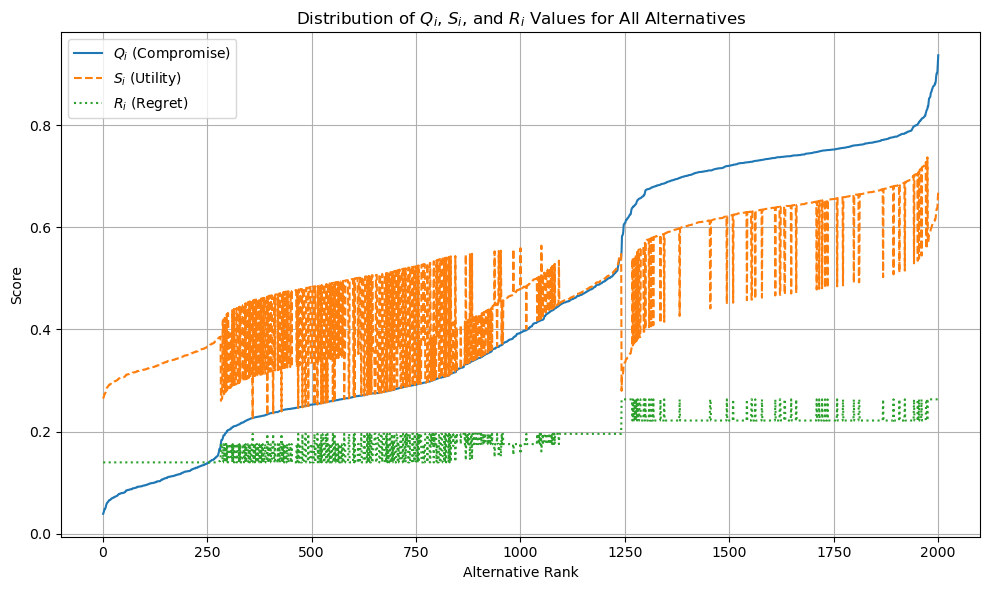

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assume Q, S, R, and rankings are already computed
# rankings: list of (index, (Q, S, R))
# Q, S, R: numpy arrays

# Build DataFrame for plotting
data = {
    'Rank': list(range(1, len(rankings) + 1)),
    'Alternative': [index + 1 for index, _ in rankings],
    'Q': [q for _, (q, _, _) in rankings],
    'S': [s for _, (_, s, _) in rankings],
    'R': [r for _, (_, _, r) in rankings]
}

df = pd.DataFrame(data)

# Plot Q_i distribution
plt.figure(figsize=(10, 6))
sns.lineplot(x='Rank', y='Q', data=df, label='$Q_i$ (Compromise)')
sns.lineplot(x='Rank', y='S', data=df, label='$S_i$ (Utility)', linestyle='--')
sns.lineplot(x='Rank', y='R', data=df, label='$R_i$ (Regret)', linestyle=':')
plt.xlabel('Alternative Rank')
plt.ylabel('Score')
plt.title('Distribution of $Q_i$, $S_i$, and $R_i$ Values for All Alternatives')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the figure (optional, good for paper inclusion)
plt.savefig('qi_si_ri_distribution.pdf')  # or .png

plt.show()


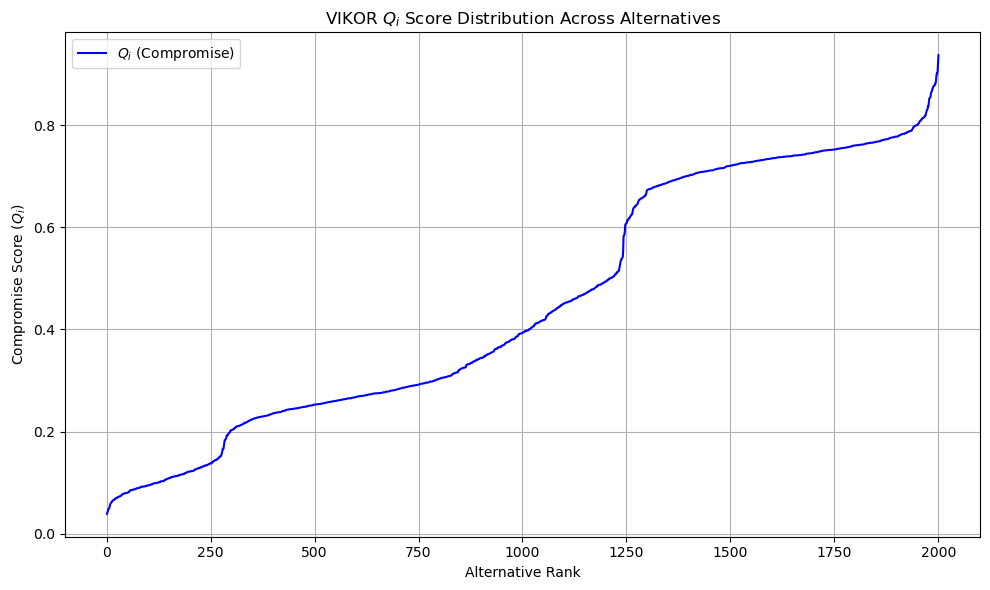

In [62]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Rank', y='Q', data=df, label='$Q_i$ (Compromise)', color='blue')
plt.xlabel('Alternative Rank')
plt.ylabel('Compromise Score ($Q_i$)')
plt.title('VIKOR $Q_i$ Score Distribution Across Alternatives')
plt.grid(True)
plt.tight_layout()
plt.savefig('qi_distribution_clean.pdf')
plt.show()


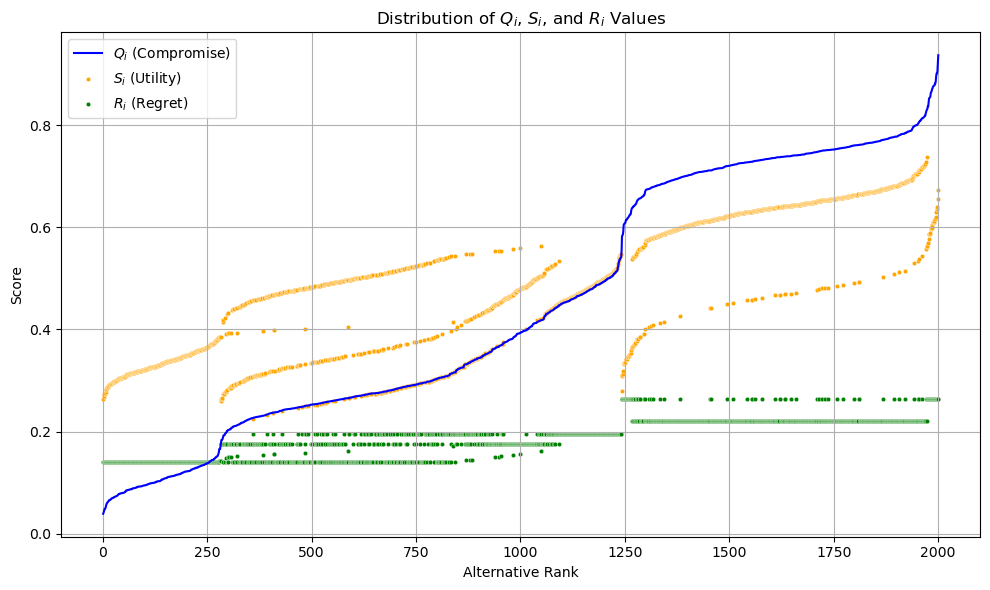

In [63]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Rank', y='Q', data=df, label='$Q_i$ (Compromise)', color='blue')
sns.scatterplot(x='Rank', y='S', data=df, label='$S_i$ (Utility)', color='orange', s=10)
sns.scatterplot(x='Rank', y='R', data=df, label='$R_i$ (Regret)', color='green', s=10)
plt.xlabel('Alternative Rank')
plt.ylabel('Score')
plt.title('Distribution of $Q_i$, $S_i$, and $R_i$ Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('qi_si_ri_scatter.pdf')
plt.show()


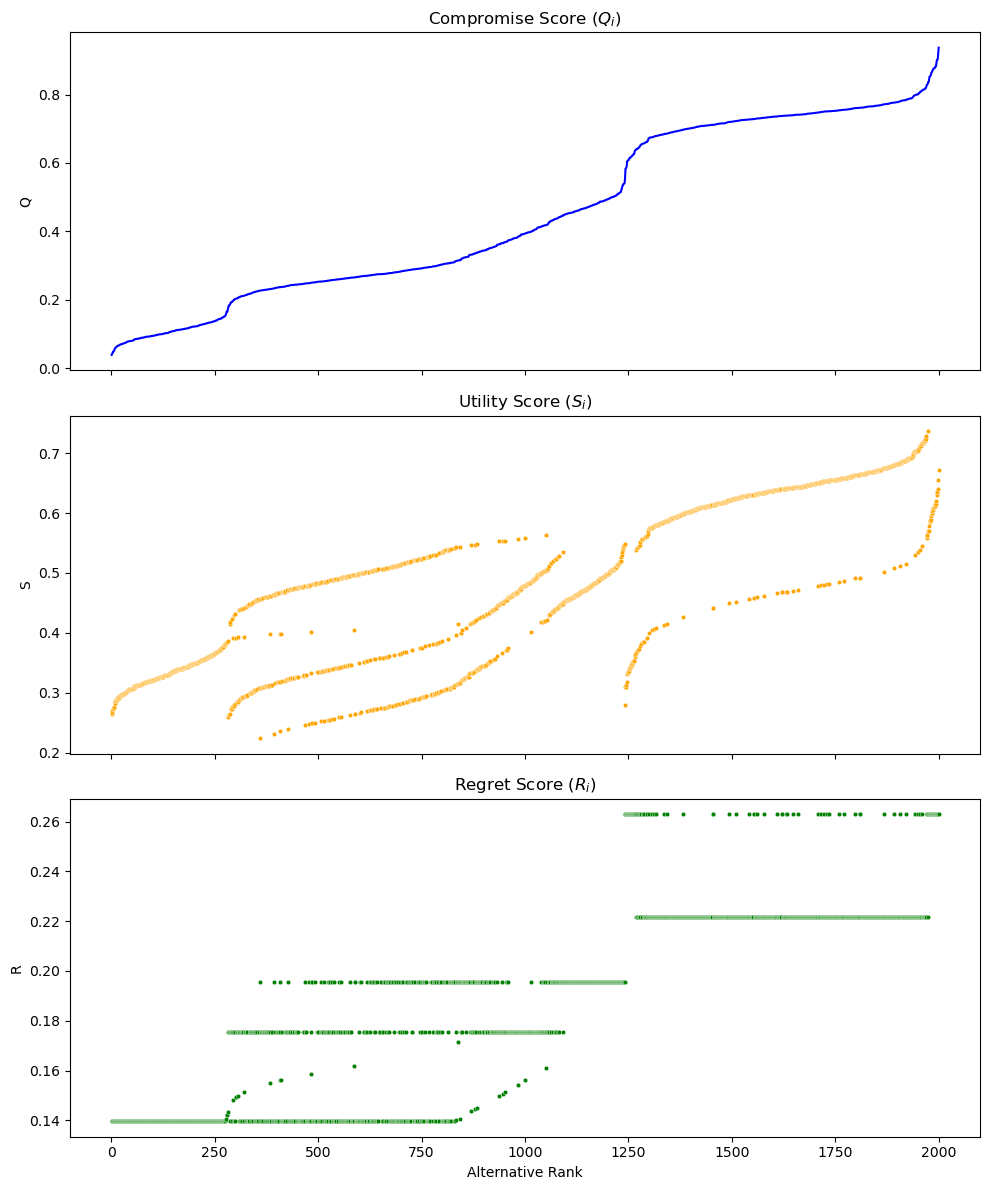

In [64]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

sns.lineplot(x='Rank', y='Q', data=df, ax=axs[0], color='blue')
axs[0].set_title('Compromise Score ($Q_i$)')
axs[0].set_ylabel('Q')

sns.scatterplot(x='Rank', y='S', data=df, ax=axs[1], color='orange', s=10)
axs[1].set_title('Utility Score ($S_i$)')
axs[1].set_ylabel('S')

sns.scatterplot(x='Rank', y='R', data=df, ax=axs[2], color='green', s=10)
axs[2].set_title('Regret Score ($R_i$)')
axs[2].set_ylabel('R')
axs[2].set_xlabel('Alternative Rank')

plt.tight_layout()
plt.savefig('qi_si_ri_subplots.pdf')
plt.show()
